El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Descargar y examinamar los datos

In [ ]:
# Cargamos las librerías

import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import randint

import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
!pip install ipython

In [ ]:
# Cargamos los datos
df = pd.read_csv("/datasets/car_data.csv")

In [ ]:
# Observamos la tabla
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [ ]:
# Revisamos la información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
# Revisamos su distribución
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


A continuación revisaremos y abordaremos el formato de las columnas, el formato de los nombres de las columnas, valores ausentes y valores duplicados. Además abordaremos otros problemas.

Al observar la distribución, pudimos ver que hay valores 0 en 'power'. **Antes que nada abordaremos esta situación para evitar sesgos en futuros cálculos**.

In [ ]:
# Revisamos qué ocurre
df[df["Power"] == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
15,11/03/2016 21:39,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,11/03/2016 00:00,0,24148,19/03/2016 08:46
32,15/03/2016 20:59,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,15/03/2016 00:00,0,44145,17/03/2016 18:17
37,28/03/2016 17:50,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,28/03/2016 00:00,0,46483,30/03/2016 09:18
40,26/03/2016 22:06,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,26/03/2016 00:00,0,56412,27/03/2016 17:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,31/03/2016 19:52,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,31/03/2016 00:00,0,41470,06/04/2016 14:18
354346,07/03/2016 17:06,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,07/03/2016 00:00,0,61169,08/03/2016 21:28
354363,27/03/2016 20:36,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,27/03/2016 00:00,0,26624,29/03/2016 10:17
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42


Esto ocurre para varios modelos. Lo que podemos hacer aquí es imputar 'Power' con la mediana en relación a los modelos.

In [ ]:
# Para evitar problemas imputamos los NaN de 'car_model' con 'Unknown_Model'
df['Model'].fillna('Unknown_Model', inplace=True)

# Calculamos las medianas
median_power_by_model = df.groupby('Model')['Power'].median()

# Función para imputar valores 0 en 'Power' según el modelo
def impute_power(row):
    if row['Power'] == 0:
        return median_power_by_model.get(row['Model'], 0)
    return row['Power']

# Aplicamos la función
df['Power'] = df.apply(impute_power, axis=1)


In [ ]:
len(df[df["Power"] == 0])

10

Ahora solo hay 10 valores con 0, estos los descartaremos.

In [ ]:
# Descartamos los 0
df = df[df["Power"] != 0]

In [ ]:
# Revisamos los cambios
len(df[df["Power"] == 0])

0

En 'Power' también podemos encontrar otros valores extraños. Aquí es razonable establecer un mínimo 'normal' ya que esto representa la potencia del motor de los vehículos. **Estableceremos 40 como valor mínimo, valor que hemos encontrado en una fuente confiable**.

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354359.000000,354359.000000,354359.000000,354359.000000,354359.000000,354359.0,354359.000000
mean,4416.759696,2004.234663,121.411014,128211.968653,5.714753,0.0,50509.061082
std,4514.176251,90.229188,186.306695,37905.085024,3.726380,0.0,25783.034433
min,0.000000,1000.000000,1.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,109.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


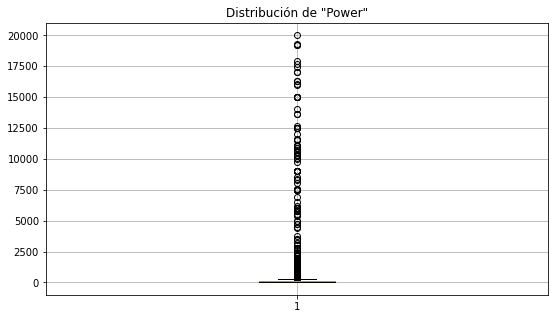

In [ ]:
# Visualizamos valores atípicos

plt.figure(figsize=(9, 5))
plt.boxplot(df['Power'])
plt.title('Distribución de "Power"')
plt.grid(True)
plt.show()

Podemos encontrar valores desde 1. Estableceremos el limite inferior como 40.

In [ ]:
# Calculamos límites superiores e inferiores
Q1 = df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)
IQR = Q3 - Q1

#lower_power = Q1 - 1.5 * IQR
lower_power = 40 ## En este caso estableceremos 40 como límite inferior
upper_power = Q3 + 1.5 * IQR

In [ ]:
# Aplicamos los límites
df = df[(df['Power'] >= lower_power) & (df['Power'] <= upper_power)]

In [ ]:
# Revisamos los cambios
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,344211.00000,344211.000000,344211.000000,344211.000000,344211.000000,344211.0,344211.000000
mean,4277.54950,2004.264129,113.995504,128405.048066,5.710003,0.0,50496.938163
std,4385.20709,87.647637,44.196201,37687.671696,3.726767,0.0,25759.656807
min,0.00000,1000.000000,40.000000,5000.000000,0.000000,0.0,1067.000000
25%,1000.00000,1999.000000,75.000000,125000.000000,3.000000,0.0,30165.000000
50%,2600.00000,2003.000000,109.000000,150000.000000,6.000000,0.0,49406.000000
75%,6000.00000,2008.000000,141.000000,150000.000000,9.000000,0.0,71065.000000
max,20000.00000,9999.000000,245.000000,150000.000000,12.000000,0.0,99998.000000


En la columna 'Price' ocurre lo mismo.

In [ ]:
# Revisamos los valores
df[df["Price"] == 0].head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,21/03/2016 18:54,0,sedan,1980,manual,50.0,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
40,26/03/2016 22:06,0,NaN,1990,NaN,60.0,corsa,150000,1,petrol,opel,NaN,26/03/2016 00:00,0,56412,27/03/2016 17:43
111,19/03/2016 18:40,0,NaN,2017,manual,95.0,golf,5000,12,petrol,volkswagen,NaN,19/03/2016 00:00,0,21698,01/04/2016 08:47
115,20/03/2016 18:53,0,small,1999,NaN,75.0,Unknown_Model,5000,0,petrol,volkswagen,NaN,20/03/2016 00:00,0,37520,07/04/2016 02:45
152,11/03/2016 18:55,0,bus,2004,manual,101.0,meriva,150000,10,lpg,opel,yes,11/03/2016 00:00,0,27432,12/03/2016 23:47


In [ ]:
# Revisamos cuántos son
len(df[df["Price"] == 0])

10400

Al revisar la distribución de la columna price podemos ver que hay valores bastante bajos. De este modo, solo dejaremos los valores desde 500 hacia arriba para obtener precios más realistas.

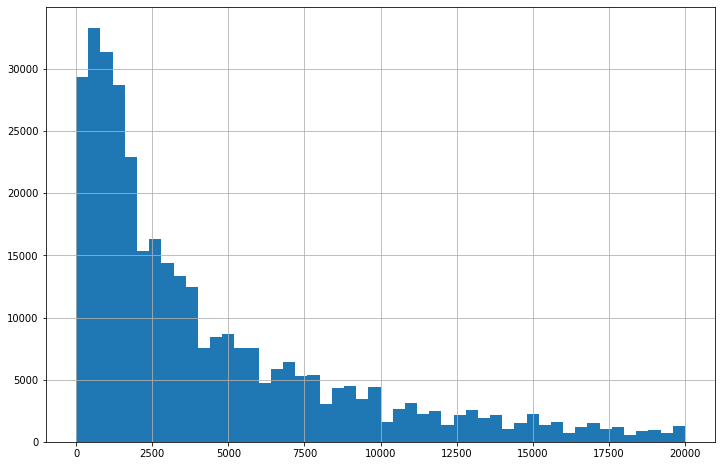

In [ ]:
# Distribución de Price
df.Price.hist(bins=50, figsize=(12, 8))
plt.show()

In [ ]:
df = df[df['Price'] >= 500]

In [ ]:
df["Price"].describe()

count    308918.000000
mean       4744.042322
std        4393.336466
min         500.000000
25%        1450.000000
50%        3099.000000
75%        6700.000000
max       20000.000000
Name: Price, dtype: float64

En la columna 'RegistrationYear' también tenemos valores extraños, cómo podemos ver en la distribución en la celda de arriba, hay valores desde el año 1000 al 9999, esto probablemente se deba a errores de tipeo o de sistema. Estableceremo los valores máximos y mínimos por medio del rango intercuartílico.

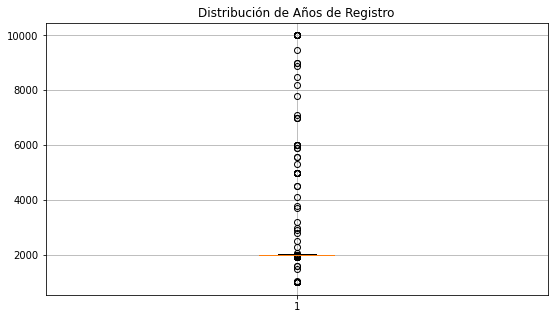

In [ ]:
# Graficamos los valores atípicos

plt.figure(figsize=(9, 5))
plt.boxplot(df['RegistrationYear'])
plt.title('Distribución de Años de Registro')
plt.grid(True)
plt.show()

In [ ]:
# Establecemos valores máximo y mínimos
Q1 = df['RegistrationYear'].quantile(0.25)
Q3 = df['RegistrationYear'].quantile(0.75)
IQR = Q3 - Q1
valor_minimo = Q1 - 1.5 * IQR
valor_maximo = Q3 + 1.5 * IQR

In [ ]:
# Revisamos los valores
print(f"""
    Límite inferior: {valor_minimo}
    Límite superior: {valor_maximo}
""")


    Límite inferior: 1985.5
    Límite superior: 2021.5      



Ahora tenemos los valores mas representativos de la variable.

In [ ]:
# Filtramos la columna
df = df[(df['RegistrationYear'] >= valor_minimo) & (df['RegistrationYear'] <= valor_maximo)].reset_index(drop=True)

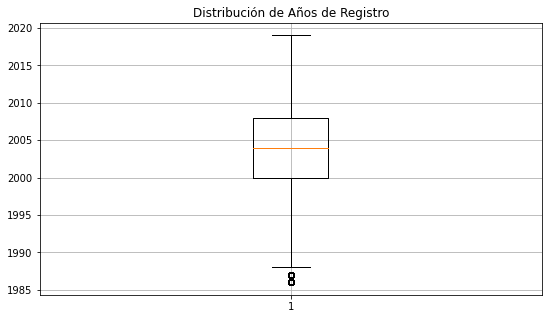

In [ ]:
# Graficamos los valores atípicos
plt.figure(figsize=(9, 5))
plt.boxplot(df['RegistrationYear'])
plt.title('Distribución de Años de Registro')
plt.grid(True)
plt.show()

**Revisamos formatos de nombres de columnas**

In [ ]:
# Revisamos nombres de columnas
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Aquí dejaremos los nombres en mínusculas y separaremos las palabras por guiones bajos.

In [ ]:
# Pasamos a minúsculas
df.columns = df.columns.str.lower()

In [ ]:
# Separamos palabras por guión bajo
new_cols = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
                    'power', 'car_model', 'mileage', 'registration_month', 'fuel_type', 'brand',
                    'not_repaired', 'date_created', 'pictures_number', 'postal_code', 'last_seen']

df.columns= new_cols

In [ ]:
# Revisamos cambios
df.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,car_model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,pictures_number,postal_code,last_seen
0,24/03/2016 10:58,18300,coupe,2011,manual,190.0,Unknown_Model,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
1,14/03/2016 12:52,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
2,17/03/2016 16:54,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40


**Ahora revisamos el formato de las columnas**

In [ ]:
# Revisamos el formato de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304376 entries, 0 to 304375
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_crawled        304376 non-null  object 
 1   price               304376 non-null  int64  
 2   vehicle_type        278388 non-null  object 
 3   registration_year   304376 non-null  int64  
 4   gearbox             292024 non-null  object 
 5   power               304376 non-null  float64
 6   car_model           304376 non-null  object 
 7   mileage             304376 non-null  int64  
 8   registration_month  304376 non-null  int64  
 9   fuel_type           282496 non-null  object 
 10  brand               304376 non-null  object 
 11  not_repaired        252492 non-null  object 
 12  date_created        304376 non-null  object 
 13  pictures_number     304376 non-null  int64  
 14  postal_code         304376 non-null  int64  
 15  last_seen           304376 non-nul

Aquí podemos ver que las columnas con fechas están en formato object, de este modo las dejaremos en formato 'datetime'.

In [ ]:
# Cambiamos los formatos de las columnas de object a datetime
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%d/%m/%Y %H:%M')
df['date_created'] = pd.to_datetime(df['date_created'], format='%d/%m/%Y %H:%M')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%d/%m/%Y %H:%M')

In [ ]:
# Comprobamos que esté todo en orden
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304376 entries, 0 to 304375
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        304376 non-null  datetime64[ns]
 1   price               304376 non-null  int64         
 2   vehicle_type        278388 non-null  object        
 3   registration_year   304376 non-null  int64         
 4   gearbox             292024 non-null  object        
 5   power               304376 non-null  float64       
 6   car_model           304376 non-null  object        
 7   mileage             304376 non-null  int64         
 8   registration_month  304376 non-null  int64         
 9   fuel_type           282496 non-null  object        
 10  brand               304376 non-null  object        
 11  not_repaired        252492 non-null  object        
 12  date_created        304376 non-null  datetime64[ns]
 13  pictures_number     304376 no

**Revisamos valores ausentes**

In [ ]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          25988
registration_year         0
gearbox               12352
power                     0
car_model                 0
mileage                   0
registration_month        0
fuel_type             21880
brand                     0
not_repaired          51884
date_created              0
pictures_number           0
postal_code               0
last_seen                 0
dtype: int64

In [ ]:
# Calcularemos el porcentaje de valores ausentes
nan_ = df.isna().sum().sum()
total_ = df.count().sum()

f"Porcentaje de valores ausentes en df: {(nan_ / total_)*100}%"

'Porcentaje de valores ausentes en df: 2.356159592695283%'

A modo de analisis podríamos hacer lo siguiente:

Aquí hay varios valores que podemos recuperar por correlación.
- 1. Los valores de 'vehicle_type' lo podemos imputar en base a la columna 'car_model'


- 2. La columna 'gearbox' se podría imputar en relación a 'car_model', pero NO lo haremos, ya que existen versiones de modelos manuales y automáticas. De este modo descartaremos estos datos para no sesgar la información.


- 3. Sobre 'car_model' no tenemos la suficiente información para imputar sus valores ausentes, por lo que los descartaremos.


- 4. En cuanto a 'fuel_type' podríamos imputar valores en relación a 'power' y a 'car_model'. Estas carácterísticas a menúdo están asociadas al tipo de combustible.

- 5. Por último, sobre 'not_repaired' no tenemos forma de saber esta información, por lo que descartaremos sus valores ausentes.

Abordamos 'vehicle_type'. Aquí crearemos un diccionario con el tipo de vehículo más frecuente para cada modelo.

In [ ]:
# Creamos el diccionario
model_vehicle_dict = {}

for model, group in df.groupby('car_model'):
    if not group['vehicle_type'].empty:
        mode_result = group['vehicle_type'].mode()
        if not mode_result.empty:
            most_frequent_vehicle_type = mode_result.iloc[0]
            model_vehicle_dict[model] = most_frequent_vehicle_type
        else:
            model_vehicle_dict[model] = "unknown"
    else:
        model_vehicle_dict[model] = "unknown"

In [ ]:
# Imputamos los valores
df['vehicle_type'].fillna(df['car_model'].map(model_vehicle_dict), inplace=True)

In [ ]:
# Revisamos los cambios
df.vehicle_type.isna().sum()

0

Abordamos 'fuel_type'. Crearemos un diccionario bansandonos en 'power' y 'car_model'.

In [ ]:
# Creamos el diccionario
fuel_type_dict = {}
for _, row in df.iterrows():
    car_model = row['car_model']
    power = row['power']
    fuel_type = row['fuel_type']
    if (car_model, power) not in fuel_type_dict:
        fuel_type_dict[(car_model, power)] = fuel_type

In [ ]:
# Imputamos los NaN de 'fuel_type'
df['fuel_type'].fillna(df.apply(lambda row: fuel_type_dict.get((row['car_model'], row['power']), row['fuel_type']), axis=1), inplace=True)

In [ ]:
# Revisamos los cambios
df.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox               12352
power                     0
car_model                 0
mileage                   0
registration_month        0
fuel_type              2884
brand                     0
not_repaired          51884
date_created              0
pictures_number           0
postal_code               0
last_seen                 0
dtype: int64

In [ ]:
# Imputamos los demás valores ausentes con 'unknown'
df.fillna('unknown', inplace=True)

In [ ]:
# Revisamos los cambios
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
car_model             0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
pictures_number       0
postal_code           0
last_seen             0
dtype: int64

**Revisamos valores duplicados**

In [ ]:
# Revisamos duplicados
df.duplicated().sum()

250

In [ ]:
# Descartamos datos duplicados
df.drop_duplicates(inplace=True)

In [ ]:
# Revisamos los cambios
df.duplicated().sum()

0

In [ ]:
# Reseteamos el index
df.reset_index(drop=True, inplace=True)

In [ ]:
# Revisamos la tabla
df.describe()

,price,registration_year,power,mileage,registration_month,pictures_number,postal_code
count,304126.000000,304126.000000,304126.000000,304126.000000,304126.000000,304126.0,304126.000000
mean,4715.828785,2003.968654,116.956913,128571.957018,5.924926,0.0,50934.173017
std,4377.492249,6.171121,44.114148,36641.252731,3.643472,0.0,25666.627775
min,500.000000,1986.000000,40.000000,5000.000000,0.000000,0.0,1067.000000
25%,1450.000000,2000.000000,80.000000,125000.000000,3.000000,0.0,30826.000000
50%,3000.000000,2004.000000,110.000000,150000.000000,6.000000,0.0,49740.000000
75%,6650.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71364.000000
max,20000.000000,2019.000000,245.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
df.shape

(304126, 16)

Descartamos cerca del 20% de nuestros datos, pero el volumen de los datos es grande por lo que no debería ser un problema.

Ahora nuestros datos ya están listos!


## Entrenamiento del modelo

**Aplicaremos One Hot Encoder porque tenemos valores categóricos, y separamos el target y los features**
- Nuestro objetivo es 'price'.


- En cuanto a features, no utilizaremos las variables 'date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen', 'pictures_number', ya que datos como número de fotos, código postal, mes de registro o la fecha en que se creó el anuncio no servirán para hacer las predicciones de los precios de los vehículos.

In [ ]:
# Aplicamos OHE a las variables categóricas
df_encoded = pd.get_dummies(df, columns=['vehicle_type', 'gearbox', 'car_model', 'fuel_type', 'brand', 'not_repaired'])

In [ ]:
# Revisamos la nueva tabla
df_encoded.head()

,date_crawled,price,registration_year,power,mileage,registration_month,date_created,pictures_number,postal_code,last_seen,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_no,not_repaired_unknown,not_repaired_yes
0,2016-03-24 10:58:00,18300,2011,190.0,125000,5,2016-03-24,0,66954,2016-04-07 01:46:00,...,0,0,0,0,0,0,0,0,0,1
1,2016-03-14 12:52:00,9800,2004,163.0,125000,8,2016-03-14,0,90480,2016-04-05 12:47:00,...,0,0,0,0,0,0,0,0,1,0
2,2016-03-17 16:54:00,1500,2001,75.0,150000,6,2016-03-17,0,91074,2016-03-17 17:40:00,...,0,0,0,0,0,1,0,1,0,0
3,2016-03-31 17:25:00,3600,2008,69.0,90000,7,2016-03-31,0,60437,2016-04-06 10:17:00,...,0,0,0,0,0,0,0,1,0,0
4,2016-04-04 17:36:00,650,1995,102.0,150000,10,2016-04-04,0,33775,2016-04-06 19:17:00,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Establecemos el target y los features
y = df_encoded['price']
X =  df_encoded.drop(columns=['price', 'date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen', 'pictures_number'])

In [ ]:
# Dividimos los datos en un conjunto de entrenamiento y un conjunto de validación en una proporción de 75:25
random_state = 200
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=random_state)

Revisamos la distribución de los datos de entrenamiento y de prueba.

La distribución de los datos numéricos de ambos conjuntos es bastante parecida, de este modo, podemos esperar que nuestro modelo tenga un buen rendimiento predictivo. No se verá afectado por los cambios en distribución.

A continuación entrenamos un modelo con el algoritmo LinearRegression.

In [ ]:
%%time
# Entrenamos nuestro modelo

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_model_preds = linear_model.predict(X_test)

CPU times: user 14 s, sys: 8.11 s, total: 22.1 s
Wall time: 22.1 s


In [ ]:
linear_model_preds = linear_model.predict(X_test)

In [ ]:
print(f"""
Linear Model RECM: {round(mean_squared_error(y_test, linear_model_preds),4)**(1/2)}
""")


Linear Model RECM: 2509.7671075420526



Da un RECM que al parecer es grande, pero en realidad no lo es, esto lo causa la naturaleza de nuestro 'target'. Vamos a revisar su distribución:

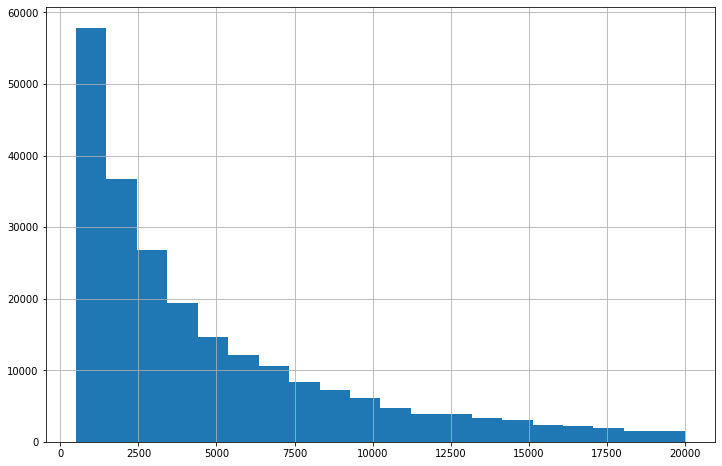

In [ ]:
# Revisamos la distribución del target
y_train.hist(bins=20, figsize=(12, 8))
plt.show()

Como podemos observar, tenemos valores más comunes desde los 500 hasta más o menos los 5000.

Ahora construiremos un modelo con RandomForestRegressor. **Decidí hacer solo 1 iteración aquí porque tomó bastante tiempo en entrenar al modelo con RandomizedSearchCV**.

In [ ]:
%%time
# Entrenamos nuestro modelo

random_forest_model = RandomForestRegressor()

distributions = dict(n_estimators=list(range(50, 150)),
                    max_depth=list(range(3, 10)),
                    criterion =["mse", "mae"])

rf_tuned = RandomizedSearchCV(random_forest_model, distributions, n_iter=1, cv=3, random_state=200)
rf_tuned.fit(X_train, y_train)

CPU times: user 9min 14s, sys: 747 ms, total: 9min 15s
Wall time: 9min 16s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                         74, 75, 76, 77, 78, 79, ...]},
                   random_state=200)

In [ ]:
rf_preds = rf_tuned.predict(X_test)

In [ ]:
f" Random Forest Model RECM: {round(mean_squared_error(y_test, rf_preds), 4)**(1/2)}"

' Random Forest Model RECM: 1900.347545950477'

Construimos un modelo con el algoritmo LightGBM.

In [ ]:
%%time
lgbm_model = lgbm.LGBMRegressor(
    learning_rate=0.5,
    random_state=200
)

grid_params = {
    'max_depth': [25, 50, 75],
    'n_estimators': [25, 50, 75],
    'objective': ['mean_squared_error', 'mean_absolute_error'],
}

lgbm_tuned = RandomizedSearchCV(lgbm_model, grid_params, cv=3, n_jobs=1, n_iter=1)
lgbm_tuned.fit(X_train, y_train)

CPU times: user 16.7 s, sys: 745 ms, total: 17.5 s
Wall time: 17.5 s


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(learning_rate=0.5, random_state=200),
                   n_iter=1, n_jobs=1,
                   param_distributions={'max_depth': [25, 50, 75],
                                        'n_estimators': [25, 50, 75],
                                        'objective': ['mean_squared_error',
                                                      'mean_absolute_error']})

In [ ]:
lgbm_preds = lgbm_tuned.predict(X_test)

In [ ]:
f"Lgbm Model RECM: {round(mean_squared_error(y_test, lgbm_preds), 4)**(1/2)}"

'Lgbm Model RECM: 1644.7519927940505'

Por último probaremos un modelo basado en CatBoostRegressor.

In [ ]:
%%time
# Entrenamos modelo CatBoostRegressor
catbr_model = CatBoostRegressor()

grid_params = {
    'depth': [6, 8, 10],
    'iterations': [50, 100, 150],
    'loss_function': ['RMSE', 'MAE'],
}

catbr_tuned = RandomizedSearchCV(catbr_model, grid_params, cv=3, n_jobs=1, n_iter=1)
catbr_tuned.fit(X_train, y_train)

Learning rate set to 0.423425
0:	learn: 3155.1119229	total: 141ms	remaining: 21s
1:	learn: 2502.8120007	total: 231ms	remaining: 17.1s
2:	learn: 2162.8707701	total: 322ms	remaining: 15.8s
3:	learn: 1973.0598328	total: 406ms	remaining: 14.8s
4:	learn: 1878.1513569	total: 484ms	remaining: 14s
5:	learn: 1817.6637242	total: 574ms	remaining: 13.8s
6:	learn: 1783.5352624	total: 664ms	remaining: 13.6s
7:	learn: 1759.4917355	total: 754ms	remaining: 13.4s
8:	learn: 1737.6532227	total: 842ms	remaining: 13.2s
9:	learn: 1717.5537261	total: 931ms	remaining: 13s
10:	learn: 1705.0546385	total: 1.01s	remaining: 12.8s
11:	learn: 1696.3305766	total: 1.1s	remaining: 12.6s
12:	learn: 1685.7809544	total: 1.18s	remaining: 12.5s
13:	learn: 1677.4165520	total: 1.27s	remaining: 12.3s
14:	learn: 1667.8253865	total: 1.35s	remaining: 12.2s
15:	learn: 1660.3487695	total: 1.44s	remaining: 12.1s
16:	learn: 1654.4945753	total: 1.53s	remaining: 12s
17:	learn: 1647.9430947	total: 1.62s	remaining: 11.9s
18:	learn: 1641.9

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f04be625070>,
                   n_iter=1, n_jobs=1,
                   param_distributions={'depth': [6, 8, 10],
                                        'iterations': [50, 100, 150],
                                        'loss_function': ['RMSE', 'MAE']})

In [ ]:
catbr_preds = catbr_tuned.predict(X_test)

In [ ]:
f"catbr Model RECM: {round(mean_squared_error(y_test, catbr_preds), 4)**(1/2)}"

'catbr Model RECM: 1500.4216602675397'

## Análisis del modelo

**Comparamos el rendimiento de los tres modelos**:

In [ ]:
print(f"""
Linear Model RECM: {round(mean_squared_error(y_test, linear_model_preds),4)**(1/2)}
Random Forest Model RECM: {round(mean_squared_error(y_test, rf_preds), 4)**(1/2)}
Lgbm Model RECM: {round(mean_squared_error(y_test, lgbm_preds), 4)**(1/2)}
catbr Model RECM: {round(mean_squared_error(y_test, catbr_preds), 4)**(1/2)}
""")


Linear Model RECM: 2509.7671075420526
Random Forest Model RECM: 1900.347545950477
Lgbm Model RECM: 1644.7519927940505
catbr Model RECM: 1500.4216602675397



- 1. El modelo LinearRegression fue el que nos arrojó el RECM más alto. Su entrenamiento duró 15 segundos.
- 2. El rendimiento mejoró al aplicar un algoritmo basado en árboles. Su entrenamiento demoró 7 minutos.
- 3. Al aplicar LightGBM obtuvimos un mejor rendimiento. Su entrenamiento tardó 17 segundos.
- 4. Por último se utilizó el algoritmo CatBoostRegressor a modo de experimento, lo cual nos dio el mejor rendimiento. Su entrenamiento tomó 40 segundos.

En síntesis, el modelo basado en CatBoostRegressor fue el que obtuvo el mejor rendimiento. Mientras que RandomForestRegressor fue el modelo que más demoró en entrenar.

## Conclusión

- 1. **Al analizar los datos**:
 - 1. Cambiamos los formatos de las columnas con fechas a datetime.
 - 2. Modificamos el formato de los nombres de las columnas.
 - 3. Descartamos valores anormales, estableciendo límites superiores e inferiores.
 - 4. Imputamos valores ausentes por medio de las correlaciones de las columnas. En otros casos no fue posible calcular valores, por lo que simplemente imputamos con 'unknown'.
 - 5. Descartamos valores duplicados y reseteamos el index.
 - 6. Por medio de este proceso descartamos cerca del 20% de los datos.


- 2. **Entrenamos cuatro modelos**:
  - LinearRegression
  - RandomForestRegressor
  - LightGBM  
  - CatBoostRegressor


- 3. **Obtuvismo los siguientes rendimientos y tiempos de entrenamiento**:
 - 1. El modelo LinearRegression fue el que nos arrojó el RECM más alto. Su entrenamiento duró 22 segundos.
 - 2. El rendimiento mejoró al aplicar un algoritmo basado en árboles. Su entrenamiento demoró 9 minutos.
 - 3. Al aplicar LightGBM obtuvimos un mejor rendimiento. Su entrenamiento tardó 17 segundos.
 - 4. Por último se utilizó el algoritmo CatBoostRegressor a modo de experimento, lo cual nos dio el mejor rendimiento. Su entrenamiento tomó 1 minuto.

 - En síntesis, el modelo basado en CatBoostRegressor fue el que obtuvo el mejor rendimiento. Mientras que RandomForestRegressor fue el modelo que más demoró en entrenar.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos